**Time-Series Project**

* Imports data from Google BigQuery - iowa_liquor_sales database
* Performs time-series analysis
* Generates a time-series forecast

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
project_id = 'sixth-flag-316719'

In [4]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [5]:
# Timeframe of the data
 
Timeframe = client.query('''
SELECT min(date), max(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`
''').to_dataframe()
 
Timeframe

,f0_,f1_
0,2012-01-03,2021-12-31


In [6]:
# check the number of distinct dates in 2018
 
numberOfDates = client.query('''
SELECT COUNT(DISTINCT date)
FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
        EXTRACT (year from date) = 2018
''').to_dataframe()
 
numberOfDates

,f0_
0,255


In [7]:
# Create table of sales from years 2017 and 2018
 
Sales = client.query('''
SELECT 
        date,
        SUM(volume_sold_liters) total_sold_liters
FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
        EXTRACT (year from date) = 2017 OR  EXTRACT (year from date) = 2018
GROUP BY
        date
''').to_dataframe()

In [8]:
import pandas as pd
import numpy as np
Sales = pd.DataFrame(Sales)
Sales = Sales.sort_values(by='date', axis=0)
Sales.set_index('date', inplace=True)

In [10]:
print(Sales.head(3))
print(Sales.tail(3))

            total_sold_liters
date                         
2017-01-03           63586.98
2017-01-04           75047.43
2017-01-05           74317.82
            total_sold_liters
date                         
2018-12-28          120241.52
2018-12-29           37739.36
2018-12-31           98802.99


# Time Series Analysis

In [11]:
# Interactive Time Series plot of Sales

import plotly.express as px

fig = px.line(Sales, y='total_sold_liters', x=Sales.index, title='Iowa Liquor Sales')
fig.update_layout(xaxis_title='Date')
fig.show()

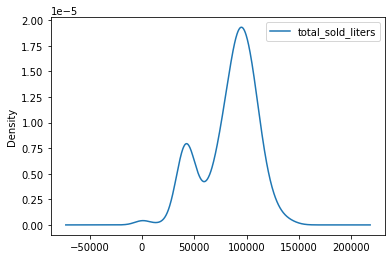

In [12]:
# Distribution Plot of Daily Sales (in liters)

Sales.plot.density()

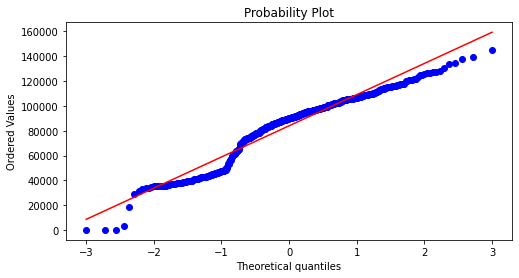

In [14]:
from scipy import stats
import matplotlib.pyplot as plt
# quantile-quantile plot of Sales
# visualize points that lie outside the line for positive and negative skews
figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
stats.probplot(Sales['total_sold_liters'], dist='norm', plot=ax)
plt.show()

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [16]:
DecompDataAdd = seasonal_decompose(Sales, model='additive', freq=1)

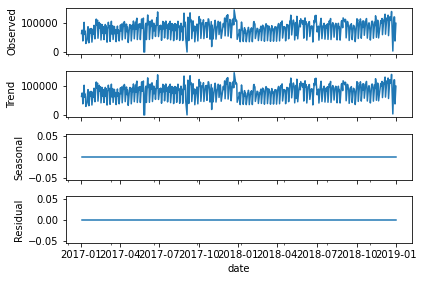

In [17]:
# Plot of seasonal decomposition

DecompDataAdd.plot();

In [18]:
# Trend and Seasonality function
from numpy import polyfit
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=260, degree=3):
    X = [i%(yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

In [20]:
data = pd.DataFrame(Sales.copy())
data.head()

,total_sold_liters
date,
2017-01-03,63586.98
2017-01-04,75047.43
2017-01-05,74317.82
2017-01-06,38077.66
2017-01-09,102171.50


Text(0, 0.5, 'Price')

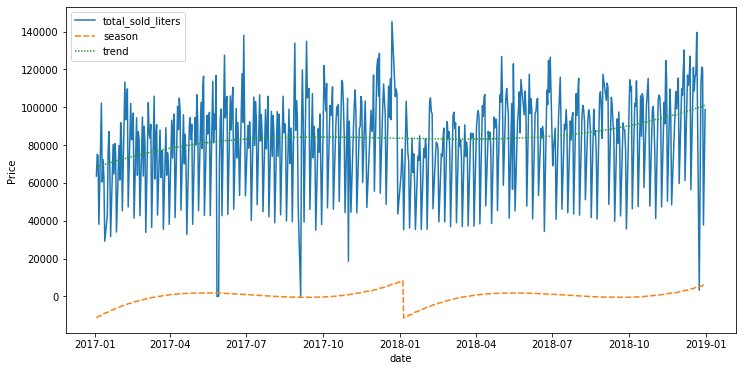

In [23]:
import seaborn as sns
data = pd.DataFrame(Sales.copy())
#Trend and Seasonality plot of Sales
plt.figure(figsize=(12, 6))
data['trend'] = get_trend(data['total_sold_liters'])
data['season'] = get_season(data['total_sold_liters'] - data['trend'])
sns.lineplot(data=data[['total_sold_liters', 'season', 'trend']])
plt.ylabel('Price')

# LSTM Model

## Train-test Split and Scale

In [ ]:
len(Sales)

512

In [ ]:
test_size = 21

In [ ]:
test_ind = len(Sales)- test_size # test index

In [ ]:
train = Sales.iloc[:test_ind] # training set
test = Sales.iloc[test_ind:] # testing set is last 21 values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 21
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(15, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=20, batch_size=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model.fit_generator(generator,epochs=25,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
470/470 [==============================] - 4s 7ms/step - loss: 0.0533 - val_loss: 0.0027
Epoch 2/25
470/470 [==============================] - 3s 6ms/step - loss: 0.0319 - val_loss: 0.0023
Epoch 3/25
470/470 [==============================] - 3s 6ms/step - loss: 0.0313 - val_loss: 0.0034
Epoch 4/25
470/470 [==============================] - 3s 6ms/step - loss: 0.0307 - val_loss: 6.7085e-05
Epoch 5/25
470/470 [==============================] - 3s 6ms/step - loss: 0.0302 - val_loss: 0.0017
Epoch 6/25
470/470 [==============================] - 3s 6ms/step - loss: 0.0300 - val_loss: 4.7951e-04
Epoch 7/25
470/470 [==============================] - 3s 7ms/step - loss: 0.0292 - val_loss: 6.6829e-04


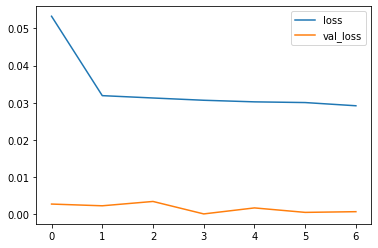

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [ ]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,total_sold_liters,Predictions
date,,
2018-12-03,109745.45,94103.331626
2018-12-04,106401.05,91671.953568
2018-12-05,120691.08,90344.743329
2018-12-06,130275.43,89339.272365
2018-12-07,61249.42,88510.787020
2018-12-10,117018.01,87884.754097
2018-12-11,111527.69,87405.735658
2018-12-12,116086.37,87045.475679
2018-12-13,126976.33,86817.773008


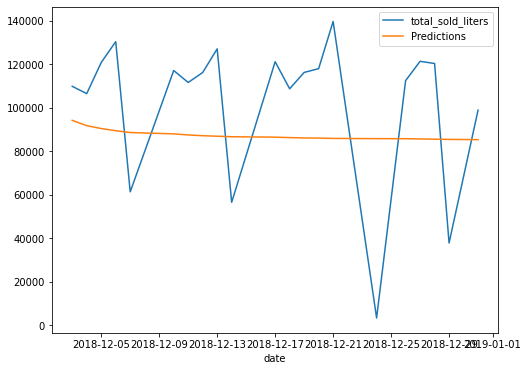

In [ ]:
test.plot(figsize=(8,6))

In [ ]:
from sklearn import metrics

In [ ]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['total_sold_liters'], test['Predictions'])))

RMSE: 36226.41548752398


# Forecast

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(Sales)

In [ ]:
length = 21 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(15, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
 
 
# fit model
model.fit_generator(generator,epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
491/491 [==============================] - 4s 6ms/step - loss: 0.0438
Epoch 2/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0333
Epoch 3/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0328
Epoch 4/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0324
Epoch 5/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0319
Epoch 6/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0317
Epoch 7/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0325
Epoch 8/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0311
Epoch 9/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0319
Epoch 10/10
491/491 [==============================] - 3s 6ms/step - loss: 0.0319


In [ ]:
forecast = []
# Replace periods with forecast length
periods = 30
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-01-01',periods=periods,freq='D')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-01-01,89523.889363
2019-01-02,89159.540835
2019-01-03,88539.484815
2019-01-04,87967.503883
2019-01-05,87441.155304
2019-01-06,87182.675915
2019-01-07,86761.564135
2019-01-08,86409.420616
2019-01-09,86066.597601
2019-01-10,85728.763999


In [ ]:
Forecast = pd.concat([Sales, forecast_df])

In [ ]:
Forecast.head()

,total_sold_liters,Forecast
2017-01-03,63586.98,NaN
2017-01-04,75047.43,NaN
2017-01-05,74317.82,NaN
2017-01-06,38077.66,NaN
2017-01-09,102171.50,NaN


In [ ]:
Forecast.tail()

,total_sold_liters,Forecast
2019-01-26 00:00:00,NaN,83709.341799
2019-01-27 00:00:00,NaN,83661.465941
2019-01-28 00:00:00,NaN,83617.895186
2019-01-29 00:00:00,NaN,83578.742142
2019-01-30 00:00:00,NaN,83543.469754


In [ ]:
# Plot of previous and forecasted data
 
import plotly.graph_objects as go
 
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['total_sold_liters'],
                    mode='lines',
                    name='total_sold_liters'))
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig2)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
public_url

In [ ]:
ngrok.kill()

# Save model and scaler

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Mounted at drive


In [ ]:
from tensorflow.keras.models import load_model
import joblib

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Projects/BigQuery/FC_model.h5')

In [ ]:
# Save the scaler
joblib.dump(scaled_full_data, '/content/drive/MyDrive/Projects/BigQuery/FC_scaler.pkl')

['/content/drive/MyDrive/Projects/BigQuery/FC_scaler.pkl']

# Load and run the model

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Mounted at drive


In [ ]:
from tensorflow.keras.models import load_model
import joblib

In [ ]:
FC_model = load_model('/content/drive/MyDrive/Projects/BigQuery/FC_model.h5')

In [ ]:
FC_scaler = joblib.load("/content/drive/MyDrive/Projects/BigQuery/FC_scaler.pkl")

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [ ]:
project_id = 'sixth-flag-316719'

In [ ]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [ ]:
# Create table of sales from years 2018 and 2017

Sales = client.query('''
SELECT 
        date,
        SUM(volume_sold_liters) total_sold_liters
FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
        EXTRACT (year from date) = 2018 OR  EXTRACT (year from date) = 2017
GROUP BY
        date
''').to_dataframe()

In [ ]:
import pandas as pd
import numpy as np
Sales = pd.DataFrame(Sales)
Sales = Sales.sort_values(by='date', axis=0)
Sales.set_index('date', inplace=True)

In [ ]:
forecast = []
# Replace periods with forecast length
periods = 30
length = 21
n_features = 1
 
first_eval_batch = FC_scaler[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = FC_model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Sales)
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-01-01',periods=periods,freq='D')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-01-01,89523.889363
2019-01-02,89159.540835
2019-01-03,88539.484815
2019-01-04,87967.503883
2019-01-05,87441.155304
2019-01-06,87182.675915
2019-01-07,86761.564135
2019-01-08,86409.420616
2019-01-09,86066.597601
2019-01-10,85728.763999


In [ ]:
Forecast = pd.concat([Sales, forecast_df])
Forecast

,total_sold_liters,Forecast
2017-01-03,63586.98,NaN
2017-01-04,75047.43,NaN
2017-01-05,74317.82,NaN
2017-01-06,38077.66,NaN
2017-01-09,102171.50,NaN
...,...,...
2019-01-26 00:00:00,NaN,83709.341799
2019-01-27 00:00:00,NaN,83661.465941
2019-01-28 00:00:00,NaN,83617.895186
2019-01-29 00:00:00,NaN,83578.742142


# Deploy the forecast with Dash and ngrok

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

     |████████████████████████████████| 1.1 MB 21.2 MB/s 
     |████████████████████████████████| 3.7 MB 61.7 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 1.8 MB 42.5 MB/s 
     |████████████████████████████████| 357 kB 61.5 MB/s 
  Created wheel for dash: filename=dash-1.21.0-py3-none-any.whl size=1100489 sha256=de7290e6105caeb7b03874313770014a3b4556104448dfb043cf9c442078a81d
  Stored in directory: /root/.cache/pip/wheels/59/a4/f1/a7140afcad8dbaa3b1b12ef80843d29403d6ecca1c2f397948
  Created wheel for dash-core-components: filename=dash_core_components-1.17.1-py3-none-any.whl size=3738995 sha256=60d8b5d99cd20e1e6491c843047688edb77fb63e2c36da48f331a795339c87a2
  Stored in directory: /root/.cache/pip/wheels/ca/5b/fb/a135a7bf8e21223e4104aa5526a5173a20b64fe7fcd055b999
  Created wheel for dash-html-components: filename=dash_html_components-1.1.4-py3-none-any.whl size=319771 sha256=ffb552320cecf5275b00607808194261a94dbd27ea630f571c9913

In [ ]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['total_sold_liters'],
                    mode='lines',
                    name='Production'))
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
 
app.run_server(mode='external')

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
public_url

In [ ]:
ngrok.kill()